# Randomized Benchmarking with the LabOne Q Software

An advanced use case example - Randomized benchmarking using the Clifford group

One applies random sequences of Clifford gates for different sequence lengths followed by a recovery gate - the resulting decay of the state fidelity as function of sequence length is a measure of overall gate fidelity

# 0. General Imports and Definitions

## 0.1 Python Imports

In [1]:
# convenience import of all LabOne Q functionality
from laboneq.simple import *

# additional imports needed for Clifford gate calculation
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import random

# helper import
from laboneq.contrib.example_helpers.data_analysis.data_analysis import *
from laboneq.contrib.example_helpers.plotting.plot_helpers import *
from laboneq.contrib.example_helpers.randomized_benchmarking_helper import *


In [2]:
## hardcoded properties:
GATE_LENGTH = 24e-9  # single Cliffordgate length
SAMPLE_RATE = 2.0e9  # sample rate of the AWG -- would be 2.4e-9 only when pulses are played with HDAWG and readout done with UHFQA
SIGMA = 1 / 3  # shape - gaussian with width = 1/3 length


# 1. Setting up the LabOne Q Software

Define the device setup, experimental parameters and baseline calibration

Establish a session and connect to it

## 1.1 Setup Descriptor

In [3]:
class MyRack:
    shfsg_address = "DEV12050"
    shfqa_address = "DEV12036"
    pqsc_address = "DEV10056"

    server_host = "10.42.11.0"
    server_port = "8004"
    setup_name = "my_setup"


rack = MyRack

my_descriptor = f"""\
instruments:
  SHFQA:
  - address: {rack.shfqa_address}   
    uid: device_shfqa
  SHFSG:
  - address: {rack.shfsg_address}
    uid: device_shfsg
  PQSC:  
  - address: {rack.pqsc_address}
    uid: device_pqsc
connections:
  device_shfqa:    
    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]
  device_shfsg:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT
  device_pqsc:
    - to: device_shfqa
      port: ZSYNCS/7
    - to: device_shfsg
      port: ZSYNCS/6    
    - internal_clock_signal
"""


## 1.2 Define Qubit / Experiment Parameters

In [4]:
# a collection of qubit control and readout parameters as a python dictionary
qubit_parameters = {
    "freq": 100e6,  # qubit 0 drive frequency in [Hz] - relative to local oscillator for qubit drive upconversion
    "ro_freq": 50e6,
    "ro_delay": 0,  # 15e-9,#100e-9,
    "ro_int_delay": 0e-9,  # 40-9,
    "qb_len_spec": 1e-6,
    "qb_len": 700e-9,
    "qb_amp_spec": 1.0,
    "pi_amp": 1,
    "qb_len": 200e-9,
    "freq_ef": -500e6,
    "ro_len": 2.0e-6,
    "ro_amp": 1,
    "relax": 1e-6,
}

# up / downconversion settings - to convert between IF and RF frequencies
lo_settings = {
    "shfqa_lo": 6.0e9,  # SHFQA LO Frequency
    "shfsg_lo": 5.0e9,  # SHFSG LO Frequencies, one center frequency per two channels
}


## 1.3 Baseline Calibration for Device Setup

In [5]:
# function that defines a setup calibration containing the qubit / readout parameters
def define_calibration(qubit_parameters, lo_settings):
    qubit0_ro_lo = Oscillator(
        uid="ro_lo_" + "q0" + "_osc",
        frequency=lo_settings["shfqa_lo"],
    )
    qubit_0_drive_lo = Oscillator(
        uid="drive_lo" + "q0" + "_osc",
        frequency=lo_settings["shfsg_lo"],
    )

    # the calibration object will later be applied to the device setup
    my_calibration = Calibration()

    ## Calibration information for qubit 0
    # qubit drive line - the calibration object contains SignalCalibration entries for each logical signal
    my_calibration["/logical_signal_groups/q0/drive_line"] = SignalCalibration(
        # each logical signal can have an oscillator associated with it
        oscillator=Oscillator(
            "q0_drive_osc",
            frequency=qubit_parameters["freq"],
            modulation_type=ModulationType.HARDWARE,
        ),
        local_oscillator=qubit_0_drive_lo,
        range=10,
    )

    # readout drive line
    my_calibration["/logical_signal_groups/q0/measure_line"] = SignalCalibration(
        oscillator=Oscillator(
            "q0_measure_osc",
            frequency=qubit_parameters["ro_freq"],
            modulation_type=ModulationType.SOFTWARE,
        ),
        port_delay=qubit_parameters["ro_delay"],
        local_oscillator=qubit0_ro_lo,
        range=10,
    )
    # acquisition line
    my_calibration["/logical_signal_groups/q0/acquire_line"] = SignalCalibration(
        oscillator=Oscillator(
            "q0_acquire_osc",
            frequency=qubit_parameters["ro_freq"],
            modulation_type=ModulationType.SOFTWARE,
        ),
        # add an offset between the readout pulse and the start of the data acquisition - to compensate for round-trip time of readout pulse
        port_delay=qubit_parameters["ro_delay"] + qubit_parameters["ro_int_delay"],
        local_oscillator=qubit0_ro_lo,
        range=-10,
        # add a threshold for the state discrimination -- this requires optimized readout integrator weights
        threshold=0.5,
    )

    return my_calibration


## 1.4 Create Device Setup and Apply Baseline Calibration

In [6]:
# define the DeviceSetup from descriptor - additionally include information on the dataserver used to connect to the instruments
my_setup = DeviceSetup.from_descriptor(
    my_descriptor,
    server_host=rack.server_host,
    server_port=rack.server_port,
    setup_name=rack.setup_name,
)

# define Calibration object based on qubit control and readout parameters
my_calibration = define_calibration(qubit_parameters, lo_settings)
# apply calibration to device setup
my_setup.set_calibration(my_calibration)


## define shortcut to logical signals for convenience
lsg_q0 = my_setup.logical_signal_groups["q0"].logical_signals
drive_Oscillator_q0 = lsg_q0["drive_line"].oscillator
readout_Oscillator_q0 = lsg_q0["measure_line"].oscillator
acquire_Oscillator_q0 = lsg_q0["acquire_line"].oscillator

# map experiment signals to logical signals
map_q0 = {
    "drive": "/logical_signal_groups/q0/drive_line",
    "measure": "/logical_signal_groups/q0/measure_line",
    "acquire": "/logical_signal_groups/q0/acquire_line",
}


## 1.5 Create a Session and Connect to it

In [7]:
emulate = True  # perform experiments in emulation mode only?

my_session = Session(device_setup=my_setup)
my_session.connect(do_emulation=emulate)


2023.03.16 17:03:03.927 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is /Users/clemensm/Zurich Instruments/CodeRepos/laboneq/examples/laboneq_output/log
2023.03.16 17:03:03.930 laboneq.controller.controller  INFO   VERSION: laboneq 1.0+local
2023.03.16 17:03:03.931 laboneq.controller.devices.device_collection INFO   Connecting to data server at 10.42.11.0:8004
2023.03.16 17:03:03.933 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.02 at 10.42.11.0:8004
2023.03.16 17:03:03.936 laboneq.controller.devices.device_collection INFO   Configuring clock sources
2023.03.16 17:03:03.938 laboneq.controller.devices.device_collection INFO   Clock sources configured


# 2. Randomized Benchmarking

Perform a randomized benchmarking experiment on a qubit

## 2.1 Additional Experimental Parameters and Pulses

Define the number of averages and the pulses used in the experiment

In [8]:
# how many averages per point: 2^n_average
n_average = 12

# qubit readout pulse
readout_pulse = pulse_library.const(
    uid="readout_pulse",
    length=qubit_parameters["ro_len"],
    amplitude=qubit_parameters["ro_amp"],
)
# integration weights for qubit measurement
readout_weighting_function = pulse_library.const(
    uid="readout_weighting_function", length=qubit_parameters["ro_len"], amplitude=1.0
)


### 2.1.1 Adjust Pulse Parameters for Clifford Gates

Calculate the basic gate set and the pulse objects corresponding to them

In [9]:
gate_length = 64e-9

gate_set = basic_gate_set(
    pi_amp=0.8,
    pi_2_amp=0.5,
    gate_time=gate_length,
    sigma=SIGMA,
    sample_rate=SAMPLE_RATE,
)
pulse_set = basic_pulse_set(gate_set)


## 2.2 Define and run the RB Experiment 
The RB experiment will consist of random sequences of different lengths, where each sequence length has a number of instances.

In [10]:
# Different sequence lengths will range from 2^1 to 2^max_seq_length
max_seq_length = 3
seq_lengths = [2**it for it in range(1, max_seq_length + 1)]

# number of different random sequences per length
n_seq_per_length = 10

# the maximum sequence duration is determined by its length,
# the max number of basic gates in each Clifford gate, and the length of each gate
max_seq_duration = 2**max_seq_length * 3 * gate_length


### Create Randomized Benchmarking Experiment
In real time (within `acquire_loop_rt`), the sequence lengths are swept, and for each sequence length, `n_seq_per_length` random sequences are created.

Each random sequence consists of three sections:
- A right-aligned drive section, which is populated by the helper function `generate_play_rb_pulses`
- A readout section
- A relax section

`generate_play_rb_pulses` first creates a random sequence of Clifford gates together with the recovery gate. Then, the Clifford gates in the sequence are decomposed into the basic gate set and played via an `Experiment.play` command.

The `handle` in the `acquire` command follows the sequence length, facilitating straight-forward result processing after the experiment.

In [11]:
exp_rb = Experiment(
    uid="RandomizedBenchmark",
    signals=[
        ExperimentSignal("drive"),
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)

# outer loop - real-time, cyclic averaging in standard integration mode
with exp_rb.acquire_loop_rt(
    uid="rb_shots",
    count=pow(2, n_average),
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.DISCRIMINATION,
):
    # inner loop - sweep over sequence lengths
    for seq_length in seq_lengths:
        # innermost loop - different random sequences for each length
        for _ in range(n_seq_per_length):
            with exp_rb.section(
                length=max_seq_duration, alignment=SectionAlignment.RIGHT
            ):
                generate_play_rb_pulses(
                    exp_rb, "drive", seq_length, clifford_parametrized, pulse_set
                )
            # readout and data acquisition
            with exp_rb.section():
                exp_rb.reserve("drive")
                exp_rb.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_rb.acquire(
                    signal="acquire",
                    handle=f"acq_{seq_length}",  # use an individual handle for every sequence length
                    kernel=readout_weighting_function,
                )
            with exp_rb.section():
                exp_rb.reserve("drive")
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_rb.delay(signal="measure", time=1e-6)


In [12]:
# set signal map for the experiment
exp_rb.set_signal_map(map_q0)

# compile the experiment
compiler_settings = {"SHFSG_MIN_PLAYWAVE_HINT": 256}
compiled_exp_rb = my_session.compile(exp_rb, compiler_settings=compiler_settings)


2023.03.16 17:03:04.865 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.03.16 17:03:04.965 laboneq.compiler.new_scheduler.scheduler INFO   Schedule completed
2023.03.16 17:03:05.104 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 355
2023.03.16 17:03:05.105 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 26432
2023.03.16 17:03:05.106 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.


In [13]:
my_results = my_session.run(compiled_exp_rb)


2023.03.16 17:03:05.173 laboneq.controller.controller  INFO   Starting near-time execution...
2023.03.16 17:03:05.177 laboneq.controller.controller  INFO   Finished near-time execution.


# Process Results and Plot
For each sequence length, the acquired results are averaged and then plotted.

In [14]:
my_results.get_data("acq_2")
avg_meas = []
for seq_length in seq_lengths:
    avg_meas.append(np.mean(my_results.get_data(f"acq_{seq_length}")))


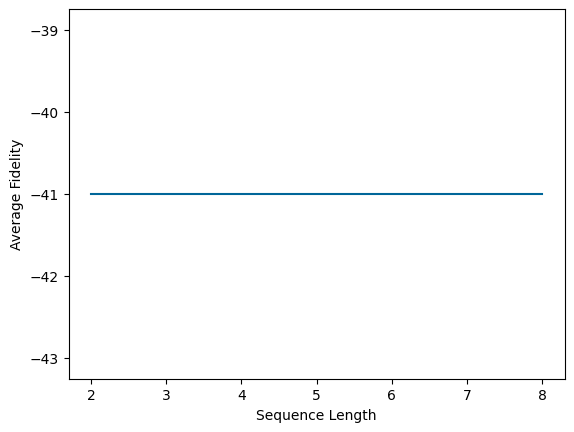

In [15]:
plt.figure()
plt.plot(seq_lengths, 1 - np.real(avg_meas))
plt.xlabel("Sequence Length")
plt.ylabel("Average Fidelity")
plt.show()
